## 1. Import Packages

In [1]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

## 2. GPU Available and Device Check

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8101741559454202281
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11830173674485103547
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


## 3. Dataset
  - DeepFashion (Category and Attribute Prediction Benchmark)
    - http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html

In [3]:
# DeepFashion Dataset Path
dataset_path = '/data/Deepfashion'
train_path = dataset_path + '/train'
validation_path = dataset_path + '/validation'
test_path = dataset_path + '/test'

## 4. Parameters & Hyperparameters

In [4]:
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 22
drop_rate = 0.4
learning_rate = 0.0001
momentum_num = 0.99

## 5. EDA

### 5 - 1. ImageDataGenerator Debugging

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

img = load_img(dataset_path + '/train/Top/Collared_Woven_Top_img_00000001_gt_98-60-200-239_iou_1.0.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                         save_to_dir='/home/azure/passion/AI/Demo/image_debugging',
                         save_prefix='top',
                         save_format='jpg'
                         ):
    i += 1
    if i>20:
        break

In [6]:
debugging_img_list = os.listdir('/home/azure/passion/AI/Demo/image_debugging')
print(debugging_img_list)

['top_0_5839.jpg', 'top_0_7266.jpg', 'top_0_2678.jpg', 'top_0_7384.jpg', 'top_0_2463.jpg', 'top_0_1976.jpg', 'top_0_151.jpg', 'top_0_2370.jpg', 'top_0_5449.jpg', 'top_0_3313.jpg', 'top_0_3078.jpg', 'top_0_6955.jpg', 'top_0_113.jpg', 'top_0_8547.jpg', 'top_0_7646.jpg', 'top_0_4548.jpg', 'top_0_9097.jpg', 'top_0_5853.jpg', 'top_0_4038.jpg', 'top_0_7051.jpg', 'top_0_540.jpg', 'top_0_7299.jpg', 'top_0_9965.jpg', 'top_0_6997.jpg', 'top_0_3742.jpg', 'top_0_8654.jpg', 'top_0_1461.jpg', 'top_0_1457.jpg', 'top_0_6777.jpg', 'top_0_1899.jpg', 'top_0_4756.jpg', 'top_0_9332.jpg', 'top_0_9805.jpg', 'top_0_663.jpg', 'top_0_9313.jpg', 'top_0_5132.jpg', 'top_0_142.jpg', 'top_0_9643.jpg', 'top_0_7206.jpg', 'top_0_8944.jpg', 'top_0_1907.jpg', 'top_0_7924.jpg', 'top_0_2824.jpg', 'top_0_8647.jpg', 'top_0_404.jpg', 'top_0_1563.jpg', 'top_0_5533.jpg', 'top_0_1440.jpg', 'top_0_6438.jpg', 'top_0_5424.jpg', 'top_0_9966.jpg', 'top_0_8025.jpg', 'top_0_198.jpg', 'top_0_9538.jpg', 'top_0_5071.jpg', 'top_0_7165.jpg'

ValueError: num must be 1 <= num <= 25, not 26

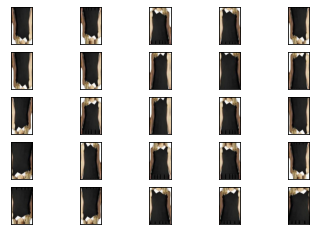

In [7]:
fig = plt.figure()
rows = 5
cols = 5
i = 1
debugging_img_path = '/home/azure/passion/AI/Demo/image_debugging'

for filename in debugging_img_list:
    img = cv2.imread(debugging_img_path + '/' + filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1

plt.show()

### 5 - 2. Data Load

In [8]:
def data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col):

    # Train
    imgdatagen_train = ImageDataGenerator(
        rescale=1./255
    )

    train_dataset = imgdatagen_train.flow_from_directory(
        train_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_train,
        class_mode='categorical',
        shuffle=True
    )

    # Validation
    imgdatagen_validatioin = ImageDataGenerator(
        rescale=1./255
    )

    validation_dataset = imgdatagen_validatioin.flow_from_directory(
        validation_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_validation,
        class_mode='categorical',
        shuffle=False
    )

    # Test
    imgdatagen_test = ImageDataGenerator(
        rescale=1./255
    )
    
    test_dataset = imgdatagen_test.flow_from_directory(
        test_path,
        target_size=(img_row, img_col),
        class_mode='categorical',
        shuffle=False
    )
    
    return train_dataset, validation_dataset, test_dataset

In [9]:
train_dataset, validation_dataset, test_dataset = data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col)

X_train, y_train = next(train_dataset)

print(X_train.shape)
print(y_train.shape)
print(y_train[1,:])

X_val, y_val = next(validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(test_dataset)

print(X_test.shape)
print(y_test.shape)

Found 204406 images belonging to 23 classes.
Found 39055 images belonging to 23 classes.
Found 39065 images belonging to 23 classes.
(64, 224, 224, 3)
(64, 23)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(64, 224, 224, 3)
(64, 23)
(32, 224, 224, 3)
(32, 23)


### 5 - 3. Data visualization - train dataset

class indices of train dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of train dataset:  [('Dress', 52137), ('Tee', 26652), ('Blouse', 19524), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Sweater', 9615), ('Cardigan', 9605), ('Jacket', 7897), ('Top', 7269), ('Jeans', 5568), ('Romper', 5424), ('Blazer', 5407), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Hoodie', 2909), ('Coat', 1601), ('Cutoffs', 1176), ('Shirts', 763), ('Poncho', 578), ('Parka', 490), ('Trunks', 286)]

Total train dataset nums:  204383



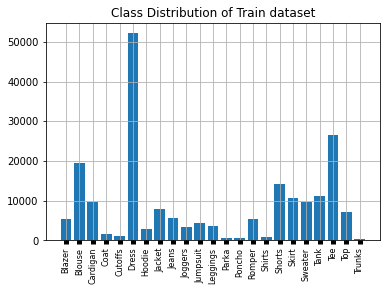

In [10]:
# Class Distribution of Train dataset
train_dataset_class_indices = train_dataset.class_indices
print("class indices of train dataset: ",train_dataset_class_indices)

category_nums = {}

for filename in train_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of train dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total train dataset nums: ", sum(category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 4. Data visualization - validation dataset

class indices of validation dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of validation dataset:  [('Dress', 10051), ('Tee', 5142), ('Blouse', 3725), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Sweater', 1839), ('Cardigan', 1827), ('Jacket', 1529), ('Top', 1396), ('Jeans', 1051), ('Blazer', 1039), ('Romper', 988), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Shirts', 129), ('Poncho', 105), ('Parka', 97), ('Trunks', 57)]

Total validation dataset nums:  39032



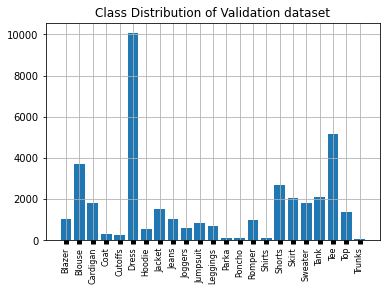

In [11]:
# Class Distribution of validation dataset
validation_dataset_class_indices = validation_dataset.class_indices
print("class indices of validation dataset: ", validation_dataset_class_indices)

category_nums = {}

for filename in validation_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of validation dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total validation dataset nums: ", sum(category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of Validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 5. Data visualization - test dataset

class indices of test dataset:  {'Blazer': 0, 'Blouse': 1, 'Cardigan': 2, 'Coat': 3, 'Cutoffs': 4, 'Dress': 5, 'Hoodie': 6, 'Jacket': 7, 'Jeans': 8, 'Joggers': 9, 'Jumpsuit': 10, 'Leggings': 11, 'Parka': 12, 'Poncho': 13, 'Romper': 14, 'Shirts': 15, 'Shorts': 16, 'Skirt': 17, 'Sweater': 18, 'Tank': 19, 'Tee': 20, 'Top': 21, 'Trunks': 22}

Sorted category nums of test dataset:  [('Dress', 9967), ('Tee', 5090), ('Blouse', 3779), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1812), ('Jacket', 1507), ('Top', 1410), ('Jeans', 1048), ('Blazer', 1046), ('Romper', 993), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Coat', 320), ('Cutoffs', 242), ('Shirts', 151), ('Poncho', 105), ('Parka', 86), ('Trunks', 40)]

Total test dataset nums:  39042



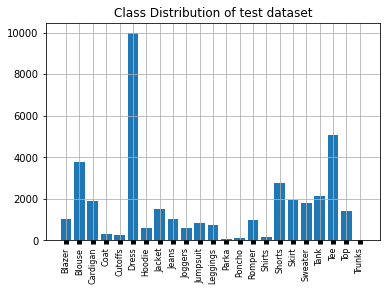

In [12]:
# Class Distribution of test dataset

test_dataset_class_indices = test_dataset.class_indices
print("class indices of test dataset: ", test_dataset_class_indices)

category_nums = {}

for filename in test_dataset.filenames:
    class_name = filename.split('/')[0]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print()       
print("Sorted category nums of test dataset: ", sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total test dataset nums: ", sum(category_nums.values()))

print()
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 5 - 6. Summary

In [13]:
class_labels = list(train_dataset.class_indices.keys())
num_imgs_validation = len(validation_dataset.filenames)
num_imgs_train = len(train_dataset.filenames)
num_imgs_test = len(test_dataset.filenames)
print("class_labels_keys: ", class_labels)
print("Length of class_labels: ", len(class_labels))
print("Number of train images: ", num_imgs_train)
print("Number of validation images: ", num_imgs_validation)
print("Number of test images: ", num_imgs_test)

class_labels_keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
Length of class_labels:  23
Number of train images:  204406
Number of validation images:  39055
Number of test images:  39065


### 6. Train dataset undersampling using Object Detection Model
    - 시간이 너무 오래걸림

In [14]:
# print(os.getcwd())

In [6]:
# image_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/static/shirtsshorts.jpg'
# labelsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/df2.names'
# weightsPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2_15000.weights'
# configPath = '/home/azure/passion/AI/YOLOv3/deepfashion2yolov3model/yolov3-df2.cfg'

In [7]:
# def object_detection(image_path, labelsPath, weightsPath, configPath):

#     # YOLO 라벨(Clothes)
#     YOLO_LABELS = open(labelsPath).read().strip().split("\n")

#     # YOLO 모델 호출
#     yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

#     # YOLO 출력층 설정
#     layer_names = yolo_net.getLayerNames()
#     output_layers = [layer_names[i[0] - 1] for i in yolo_net.getUnconnectedOutLayers()]
#     colors = np.random.uniform(0, 255, size=(len(YOLO_LABELS), 3))

#     # 영상 할당
#     file_path = image_path
#     cap = cv2.VideoCapture(file_path)

#     # 화면 폰트
#     font = cv2.FONT_HERSHEY_SIMPLEX

#     _, frame = cap.read()
#     height, width, channels = frame.shape

#     # Detecting objects
#     blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

#     yolo_net.setInput(blob)
#     outs = yolo_net.forward(output_layers)

#     # Showing informations on the screen
#     count = 0
#     class_ids = []
#     confidences = []
#     boxes = []
#     crop_labels = []
#     for out in outs:
#         for detection in out:
#             # print(detection)
#             scores = detection[5:]
#             class_id = np.argmax(scores)
#             confidence = scores[class_id]
#             if confidence > 0.5:
#                 count += 1
#                 # Object detected
#                 # center_x = int(detection[0] * width)
#                 # center_y = int(detection[1] * height)
#                 # ww = int(detection[2] * width)
#                 # hh = int(detection[3] * height)

#                 # Rectangle coordinates
#                 # xx = int(center_x - ww / 2)
#                 # yy = int(center_y - hh / 2)

#                 # boxes.append([xx, yy, ww, hh])
#                 confidences.append(float(confidence))
#                 # class_ids.append(class_id)

#                 # object detection된 이미지의 object detection label
#                 crop_label = YOLO_LABELS[class_id]
#                 print(crop_label)
#                 # print(confidence)

#                 # object detection된 이미지 중 label이 중복된 값이 있다면 confidence가 높은 이미지 채택
#                 # crop_labels.append(crop_label)

#                 # crop_img = frame[yy:yy + hh, xx:xx + hh]
                
#                 if crop_label == 'short_sleeve_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) + ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'long_sleeve_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) + ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'vest_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) +  ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 elif crop_label == 'sling_dress':
#                     # cv2.imwrite('/home/azure/passion/AI/Demo/tmp/' +  crop_label + "_" + str(count) + "_" + str(confidence) +  ".jpg", crop_img)
#                     # print(crop_label)                
#                     return crop_label
#                 else:
#                     continue

In [8]:
# train_paths = []

# for f in glob.glob(train_path + '/' + 'Dress' + '/*.jpg'):
#     train_paths.append(f)

# print(train_paths[:1])

['/data/Deepfashion/train/Dress/Open-Knit_High-Slit_Maxi_Dress_img_00000001_gt_92-37-195-300_iou_1.0.jpg']


In [9]:
# dress_labeled_path = []
# for path in train_paths:
#     label = object_detection(path, labelsPath, weightsPath, configPath)
#     if label == 'short_sleeve_dress':
#         dress_labeled_path.append(path)
#     elif label == 'long_sleeve_dress':
#         dress_labeled_path.append(path)
#     elif label == 'vest_dress':
#         dress_labeled_path.append(path)
#     elif label == 'sling_dress':
#         dress_labeled_path.append(path)

# print(len(dress_labeled_path))

short_sleeve_dress
sling_dress
sling_dress
skirt
long_sleeve_dress
sling_dress
sling_dress
short_sleeve_dress
sling_dress
sling_dress
vest_dress
sling_dress
skirt
short_sleeve_dress
vest_dress
vest_dress
long_sleeve_top
long_sleeve_top
vest_dress
short_sleeve_top
short_sleeve_top
short_sleeve_top
short_sleeve_top
long_sleeve_dress
sling_dress
skirt
long_sleeve_dress
skirt
vest_dress
short_sleeve_dress
vest_dress
long_sleeve_dress
short_sleeve_top
short_sleeve_dress
sling_dress
short_sleeve_dress
short_sleeve_dress
long_sleeve_dress
long_sleeve_dress
skirt
short_sleeve_top
short_sleeve_dress
long_sleeve_dress
short_sleeve_dress
short_sleeve_dress
long_sleeve_dress
long_sleeve_dress
long_sleeve_top
skirt
sling_dress
sling_dress
long_sleeve_dress
sling_dress
vest_dress
vest_dress
long_sleeve_top
sling_dress
sling_dress
vest_dress
short_sleeve_dress
sling_dress
vest_dress
long_sleeve_dress
short_sleeve_top
short_sleeve_top
vest
vest_dress
short_sleeve_top
short_sleeve_dress
short_sleeve_dr

skirt
short_sleeve_dress
short_sleeve_dress
vest_dress
sling_dress
sling_dress
skirt
sling_dress
sling_dress
sling_dress
long_sleeve_dress
short_sleeve_dress
vest_dress
sling_dress
vest_dress
short_sleeve_dress
sling_dress
sling_dress
sling_dress
short_sleeve_dress
vest_dress
vest_dress
short_sleeve_dress
vest_dress
vest_dress
sling_dress
vest_dress
vest_dress
vest_dress
sling_dress
short_sleeve_top
short_sleeve_top
skirt
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
vest_dress
short_sleeve_dress
skirt
sling_dress
short_sleeve_dress
sling_dress
short_sleeve_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
vest_dress
short_sleeve_dress
vest_dress
vest_dress
sling_dress
sling_dress
long_sleeve_dress
sling_dress
long_sleeve_dress
sling_dress
long_sleeve_dress
long_sleeve_dress
long_sleeve_dress
vest_dress
vest_dress
sling_dress
sling_dress
short_sleeve_dress
vest_dress
short_sleeve_dress
short_sleeve_dress
short_sleeve_dress
vest_dress
long_sleeve_top
long_sleeve_dres

skirt
skirt
vest_dress
vest_dress
sling_dress
sling_dress
long_sleeve_dress
long_sleeve_dress
sling_dress
sling_dress
skirt
skirt
skirt
vest_dress
vest_dress
sling_dress
skirt
sling_dress
vest_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
sling_dress
skirt
skirt
sling_dress
sling_dress
skirt
vest
skirt
short_sleeve_dress
vest_dress
short_sleeve_top
short_sleeve_top
sling_dress
vest_dress
short_sleeve_top
vest_dress
sling_dress
vest_dress
sling_dress
sling_dress
sling_dress
skirt
sling_dress
skirt
sling_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
sling_dress
sling_dress
long_sleeve_dress
sling_dress
sling_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
sling_dress
sling_dress
vest_dress
vest_dress
long_sleeve_dress
long_sleeve_dress
short_sleeve_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
skirt
skirt
sling_dress
long_sleeve_dress
sling_dress
shorts
sling_dress
sling_dress
sling_dress
sling_dress
slin

sling_dress
sling_dress
sling_dress
vest_dress
vest_dress
vest_dress
short_sleeve_dress
vest_dress
long_sleeve_dress
short_sleeve_dress
vest_dress
vest_dress
vest_dress
long_sleeve_dress
vest_dress
sling_dress
sling_dress
sling_dress
vest_dress
sling_dress
short_sleeve_dress
vest
skirt
skirt
vest_dress
sling_dress
sling_dress
vest_dress
vest_dress
skirt
skirt
vest_dress
vest_dress
sling_dress
vest_dress
skirt
skirt
vest_dress
sling_dress
short_sleeve_dress
vest_dress
short_sleeve_dress
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
short_sleeve_dress
short_sleeve_dress
short_sleeve_top
short_sleeve_dress
short_sleeve_dress
sling_dress
short_sleeve_top
sling_dress
short_sleeve_dress
long_sleeve_dress
short_sleeve_top
short_sleeve_dress
skirt
short_sleeve_dress
skirt
short_sleeve_dress
short_sleeve_dress
short_sleeve_dress
vest_dress
long_sleeve_dress
short_sleeve_dress
short_sleeve_dress
short_sleeve_dress
vest_dress
vest_dress
skirt
skirt
long_sleeve_dress
long_sleeve_dress
long_

long_sleeve_top
long_sleeve_top
sling_dress
long_sleeve_dress
long_sleeve_dress
long_sleeve_dress
long_sleeve_top
long_sleeve_dress
long_sleeve_top
sling_dress
long_sleeve_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
long_sleeve_dress
skirt
long_sleeve_top
long_sleeve_dress
long_sleeve_top
long_sleeve_dress
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
short_sleeve_dress
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
long_sleeve_dress
long_sleeve_dress
long_sleeve_top
long_sleeve_top
long_sleeve_top
long_sleeve_dress
long_sleeve_dress
short_sleeve_dress
vest_dress
sling_dress
sling_dress
vest_dress
vest_dress
long_sleeve_dress
short_sleeve_dress
short_sleeve_dress
short_sleeve_dress
long_sleeve_dress
vest_dress
vest_dress
short_sleeve_dress
long_sleeve_dress
sling_dress
vest_dress
vest_dress
long_sleeve_t

vest_dress
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
long_sleeve_outwear
long_sleeve_outwear
long_sleeve_dress
vest_dress
short_sleeve_dress
long_sleeve_dress
long_sleeve_dress
sling_dress
vest_dress
sling_dress
vest_dress
sling_dress
vest_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
vest_dress
sling_dress
short_sleeve_dress
sling_dress
sling_dress
short_sleeve_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
sling_dress
short_sleeve_dress
vest_dress
sling_dress
sling_dress
sling_dress
short_sleeve_dress
long_sleeve_dress
sling_dress
sling_dress
vest_dress
long_sleeve_top
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
long_sleeve_top
long_sleeve_dress
short_sleeve_dress
sling_dress
sling_dress
sling_dress
sling_dress
vest_dress
sling_dress
vest_dress
sling_dress
vest_dress
vest_dress
long_sleeve_dress
vest_dress
sling_dress
short_sleeve_dress
vest_dress
short_sleeve_dress
short_sleeve_top
short_sleeve_top


KeyboardInterrupt: 

### 7. Train Data Oversampling & Undersampling

In [18]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
# print(len(class_names))
# train_paths = []

# for cls in class_names:
#     for f in glob.glob(train_path + '/' + cls + '/*.jpg'):
#         if cls == 'Dress':
#             train_paths.append(f)
#         elif cls == 'Trunks':
#             for i in range(34):
#                 train_paths.append(f)
#         elif cls == 'Shirts':
#             for i in range(13):
#                 train_paths.append(f)
#         elif cls == 'Parka':
#             for i in range(20):
#                 train_paths.append(f)
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths.append(f)
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths.append(f)
#         elif cls == 'Jeans':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Joggers':
#             for i in range(3):
#                 train_paths.append(f)
#         elif cls == 'Hoodie':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Leggings' or cls == 'Jumpsuit' or cls == 'Romper' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Top' or cls == 'Jacket' or cls == 'Sweater' or cls == 'Cardigan' or cls == 'Skirt' or cls == 'Tank' or cls == 'Shorts' or cls == 'Tee' or cls == 'Blouse':
#             train_paths.append(f)

# print(train_paths[0])
# print(len(train_paths))

# train_paths_class = []

# for cls in class_names:
#     for f in glob.glob(train_path + '/' + cls + '/*.jpg'):
#         if cls == 'Dress':
#             train_paths_class.append(f.split('/')[4])
#         elif cls == 'Trunks':
#             for i in range(34):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Shirts':
#             for i in range(13):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Parka':
#             for i in range(20):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Jeans':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Joggers':
#             for i in range(3):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Hoodie':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Leggings' or cls == 'Jumpsuit' or cls == 'Romper' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[4])
#         elif cls == 'Top' or cls == 'Jacket' or cls == 'Sweater' or cls == 'Cardigan' or cls == 'Skirt' or cls == 'Tank' or cls == 'Shorts' or cls == 'Tee' or cls == 'Blouse':
#             train_paths_class.append(f.split('/')[4])        

# print(train_paths_class[0])
# print(len(train_paths_class))

# train_df = {'filepath': train_paths, 'class_name': train_paths_class}
# df_train = pd.DataFrame(train_df)
# print(df_train.head())

# train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain.csv'
# df_train.to_csv(train_csv_path)

23
/data/Deepfashion/train/Blazer/Single-Button_Blazer_img_00000001_gt_30-61-266-294_iou_1.0.jpg
281911
Blazer
281911
                                            filepath class_name
0  /data/Deepfashion/train/Blazer/Single-Button_B...     Blazer
1  /data/Deepfashion/train/Blazer/Single-Button_B...     Blazer
2  /data/Deepfashion/train/Blazer/Single-Button_B...     Blazer
3  /data/Deepfashion/train/Blazer/Single-Button_B...     Blazer
4  /data/Deepfashion/train/Blazer/Single-Button_B...     Blazer


In [14]:
train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
1,1,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
2,2,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
3,3,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer
4,4,/data/Deepfashion/train/Blazer/Single-Button_B...,Blazer


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_train
)

Found 222107 validated image filenames belonging to 22 classes.


In [16]:
category_nums = {}

print(train_generator.filenames[0].split('/')[4])

for filename in train_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Dress', 14336), ('Shorts', 14194), ('Blouse', 12522), ('Tee', 11651), ('Tank', 11203), ('Jeans', 11137), ('Romper', 10849), ('Blazer', 10815), ('Skirt', 10793), ('Shirts', 9931), ('Parka', 9819), ('Joggers', 9779), ('Trunks', 9757), ('Sweater', 9615), ('Coat', 9611), ('Cardigan', 9605), ('Cutoffs', 9415), ('Jumpsuit', 8927), ('Jacket', 7897), ('Top', 7269), ('Leggings', 7141), ('Hoodie', 5819)]
222085


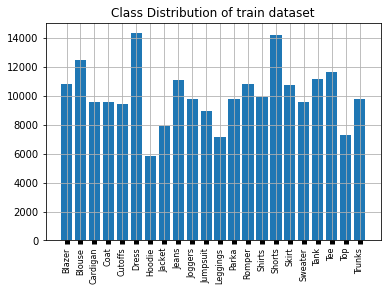

In [17]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

# Blouse -= 7000
# Dress -= 38000
# Tee -= 15000

### 8. Validation dataset Dress Category Undersampling

In [27]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']

# validation_paths = []

# for cls in class_names:
#     for f in glob.glob(validation_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             validation_paths.append(f)

# print(validation_paths[0])
# print(len(validation_paths))

# validation_paths_class = []

# for cls in class_names:
#     for f in glob.glob(validation_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             validation_paths_class.append(f.split('/')[4])
        

# print(validation_paths_class[0])
# print(len(validation_paths_class))

# validation_df = {'filepath': validation_paths, 'class_name': validation_paths_class}
# df_validation = pd.DataFrame(validation_df)
# print(df_validation.head())

# validation_csv_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/sampling_dataframe/demovalidation.csv'
# df_validation.to_csv(validation_csv_path)

In [18]:
validation_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demovalidation.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
1,1,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
2,2,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
3,3,/data/Deepfashion/validation/Blazer/Single-But...,Blazer
4,4,/data/Deepfashion/validation/Blazer/Single-But...,Blazer


In [19]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_validation
)

Found 33948 validated image filenames belonging to 22 classes.


In [20]:
category_nums = {}

print(validation_generator.filenames[0].split('/')[4])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Tee', 5142), ('Dress', 5050), ('Blouse', 3725), ('Shorts', 2699), ('Tank', 2096), ('Skirt', 2045), ('Sweater', 1839), ('Cardigan', 1827), ('Jacket', 1529), ('Top', 1396), ('Jeans', 1051), ('Blazer', 1039), ('Romper', 988), ('Jumpsuit', 839), ('Leggings', 717), ('Joggers', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Shirts', 129), ('Parka', 97), ('Trunks', 57)]
33926


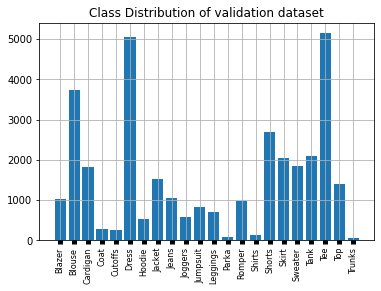

In [21]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 9. Test dataset Dress Category Undersampling

In [32]:
# class_names = ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']

# test_paths = []

# for cls in class_names:
#     for f in glob.glob(test_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             test_paths.append(f)

# print(test_paths[0])
# print(len(test_paths))

# test_paths_class = []

# for cls in class_names:
#     for f in glob.glob(test_path + '/' + cls + '/*.jpg'):
#         if cls != 'Poncho':
#             test_paths_class.append(f.split('/')[4])        

# print(test_paths_class[0])
# print(len(test_paths_class))

# test_df = {'filepath': test_paths, 'class_name': test_paths_class}
# df_test = pd.DataFrame(test_df)
# print(df_test.head())

# test_csv_path = '/home/azure/passion/AI/CategoryandAttributePredictionBenchmark/dataset/sampling_dataframe/demotest.csv'
# df_test.to_csv(test_csv_path)

In [22]:
test_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotest.csv'
test_df = pd.read_csv(test_csv_path)
test_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
1,1,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
2,2,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
3,3,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer
4,4,/data/Deepfashion/test/Blazer/Single-Button_Bl...,Blazer


In [23]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col)
)

Found 33958 validated image filenames belonging to 22 classes.


In [24]:
category_nums = {}

print(test_generator.filenames[0].split('/')[4])

for filename in test_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Tee', 5090), ('Dress', 4966), ('Blouse', 3779), ('Shorts', 2770), ('Tank', 2127), ('Skirt', 1932), ('Cardigan', 1876), ('Sweater', 1812), ('Jacket', 1507), ('Top', 1410), ('Jeans', 1048), ('Blazer', 1046), ('Romper', 993), ('Jumpsuit', 848), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Coat', 320), ('Cutoffs', 242), ('Shirts', 151), ('Parka', 86), ('Trunks', 40)]
33936


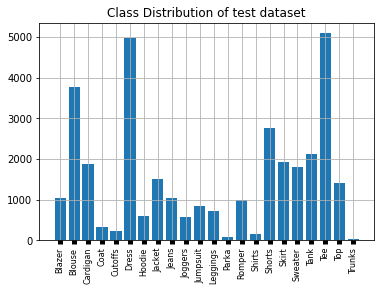

In [25]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

### 10. Sampling Summary

In [26]:
class_labels_sampling = list(train_generator.class_indices.keys())
print("class labels sampling keys: ", class_labels_sampling)
print("The number of class labels: ", len(class_labels_sampling))
num_imgs_train_sampling = len(train_generator.filenames)
print("The number of train images sampling: ", num_imgs_train_sampling)
num_imgs_validation_sampling = len(validation_generator.filenames)
print("The number of validation images sampling: ", num_imgs_validation_sampling)
num_imgs_test_sampling = len(test_generator.filenames)
print("The number of testimages sampling: ", num_imgs_test_sampling)

class labels sampling keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
The number of class labels:  22
The number of train images sampling:  222107
The number of validation images sampling:  33948
The number of testimages sampling:  33958


### 11. VGG Model Building

In [27]:
# Initialize tne VGG model
vgg_conv = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(img_row, img_col, img_channel),
                 pooling='avg'
                )

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff241dd14a8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff241140b00> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff24112a898> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff2410e2c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2410e8d68> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2410f3f28> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff2410fa630> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2408810b8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff240881f28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff24088b630> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff24088b5c0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff240881

In [30]:
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers - Dense, BatchNorm, Activation
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(22))
    model.add(Activation('softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [31]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                11286     
_________________________________________________________________
activation_2 (Activation)    (None, 22)               

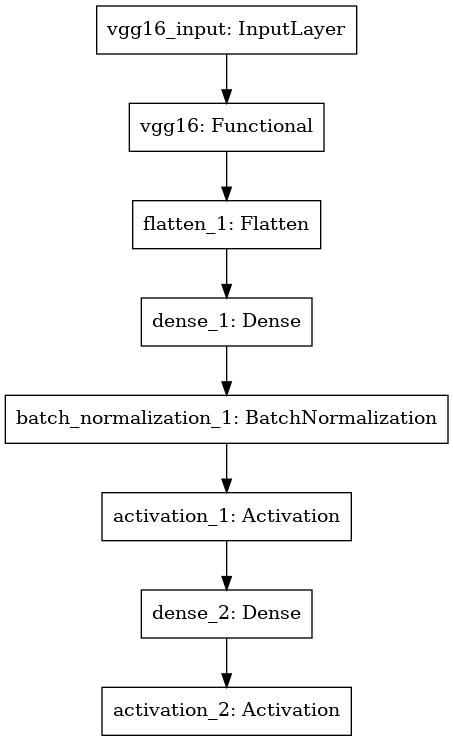

In [33]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Demo/output/model_summary/demo_model.jpg')

### 12. Plotting Accuracy & Loss Curves

In [34]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/demo_model_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/demo_model_loss.jpg')
    plt.show()

### 13. Register Callbacks

In [35]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Demo/output/csv_logger/demo_model.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=500, verbose=1, mode='min'
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Demo/output/checkpoint/demo_model.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, check_point]
    return callback_list

In [36]:
callback_list = callback()

### 14. Fine-tune the model - Training

In [39]:
def fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=num_imgs_train_sampling//batch_size_train,
        validation_data=validation_generator,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

Epoch 1/10
3470/3470 [==============================] - 3346s 958ms/step - loss: 1.2703 - accuracy: 0.6023 - val_loss: 1.2148 - val_accuracy: 0.6178
Epoch 2/10
3470/3470 [==============================] - 3304s 952ms/step - loss: 0.7353 - accuracy: 0.7661 - val_loss: 1.2262 - val_accuracy: 0.6189
Epoch 3/10
3470/3470 [==============================] - 3293s 949ms/step - loss: 0.5671 - accuracy: 0.8173 - val_loss: 1.1358 - val_accuracy: 0.6584
Epoch 4/10
3470/3470 [==============================] - 3294s 949ms/step - loss: 0.4169 - accuracy: 0.8632 - val_loss: 1.2755 - val_accuracy: 0.6309
Epoch 5/10
3470/3470 [==============================] - 3292s 949ms/step - loss: 0.2958 - accuracy: 0.9023 - val_loss: 1.2647 - val_accuracy: 0.6654
Epoch 6/10
3470/3470 [==============================] - 3284s 946ms/step - loss: 0.2043 - accuracy: 0.9330 - val_loss: 1.4692 - val_accuracy: 0.6513
Epoch 7/10
3470/3470 [==============================] - 3283s 946ms/step - loss: 0.1386 - accuracy: 0.9542

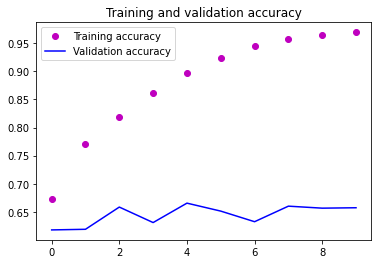

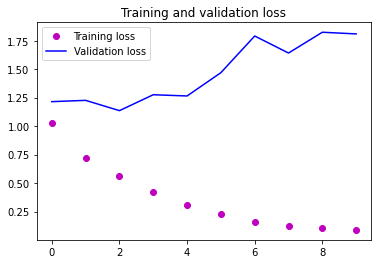

Validation Accuracy:0.6572405099868774 
Validation Loss:1.8094594478607178


In [40]:
model, history, score = fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

# Model Save
model.save('/home/azure/passion/AI/Demo/output/demo_model.h5')

### 15. Prediction

In [41]:
model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/demo_model.ckpt')
Y_pred = model.predict(test_generator)

In [42]:
testY_labels = test_generator.labels
print(testY_labels)
print(len(testY_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 16. Confusion Matrix and Classification Report

In [45]:
def confusion_mat(Y_pred, testY_labels, class_labels_sampling):
    y_pred = np.argmax(Y_pred, axis=1)
    confusion_mat = confusion_matrix(testY_labels, y_pred)
    classification_rep = classification_report(testY_labels, y_pred, target_names=class_labels_sampling)
    plt.figure(figsize=(6, 4))
    df_confusion_mat = pd.DataFrame(confusion_mat)
    sns.heatmap(df_confusion_mat, annot_kws={"size": 5}, linewidths=.5, cmap='PuBu',
               annot=True, yticklabels=class_labels_sampling, xticklabels=class_labels_sampling, fmt='g'
               )
    plt.xticks(rotation=90)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/demo_model_confusion_matrix.jpg')
    return plt, classification_rep

              precision    recall  f1-score   support

      Blazer       0.04      0.04      0.04      1047
      Blouse       0.12      0.08      0.10      3780
    Cardigan       0.06      0.08      0.07      1877
        Coat       0.01      0.01      0.01       321
     Cutoffs       0.01      0.01      0.01       243
       Dress       0.14      0.12      0.13      4967
      Hoodie       0.03      0.01      0.02       597
      Jacket       0.04      0.07      0.05      1508
       Jeans       0.04      0.04      0.04      1049
     Joggers       0.01      0.01      0.01       575
    Jumpsuit       0.03      0.04      0.03       849
    Leggings       0.02      0.02      0.02       724
       Parka       0.00      0.00      0.00        87
      Romper       0.02      0.04      0.03       994
      Shirts       0.00      0.01      0.00       152
      Shorts       0.08      0.07      0.08      2771
       Skirt       0.06      0.06      0.06      1933
     Sweater       0.06    

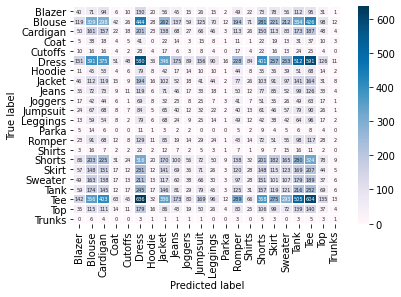

In [46]:
confusion_mat, classification_report = confusion_mat(Y_pred, testY_labels, class_labels_sampling)
print(classification_report)

In [47]:
model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/demo_model.ckpt')

loss, acc = model.evaluate(test_generator)
print("loss: ", loss)
print("acc: ", acc)

1062/1062 [==============================] - 138s 130ms/step - loss: 1.1622 - accuracy: 0.6501
loss:  1.162157416343689
acc:  0.6500677466392517


### 17. Conversion to tensorflow lite

In [48]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Demo/output/demo_model_serving.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0pgpjmm_/assets


59965344